{'size': 128, 'clr': Array([0.47, 0.48, 0.5 ], dtype=float32), 'sub_size': {8: 90, 10: 92, 12: 98}, 'sub_clr': Array([0.75, 0.75, 0.75], dtype=float32), 'action_clr': Array([1, 1, 0], dtype=int32), 'trea_clr': Array([0.29, 0.84, 0.97], dtype=float32), 'grid_px': 2, 'grid_clr': Array([1, 1, 1], dtype=int32), 'sc_t_l': (43, 1), 'sc_b_r': (85, 15), 'sc_clr': Array([0. , 1. , 0.5], dtype=float32), 'env_t_l': (0, 115), 'env_b_r': (128, 128), 'env_clr': Array([0.29, 0.84, 0.97], dtype=float32)}
18 18


/Users/zeka/anaconda3/envs/rl_dev/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:121: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


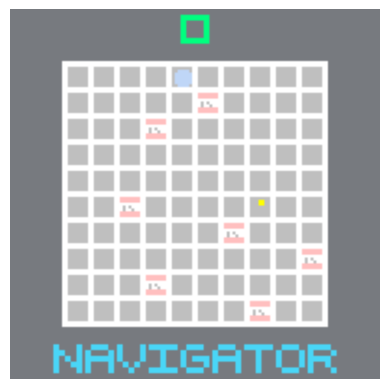

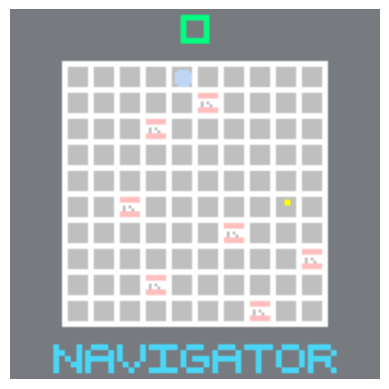

In [1]:
import popgym_arcade
import jax
from matplotlib import pyplot as plt

# Create both POMDP and MDP env variants
pomdp, pomdp_params = popgym_arcade.make("CartPoleEasy", partial_obs=True, obs_size=128)
mdp, mdp_params = popgym_arcade.make("NavigatorMedium", partial_obs=False, obs_size=128)

# Let's vectorize and compile the envs
# Note when you are training a policy, it is better to compile your policy_update rather than the env_step
pomdp_reset = jax.jit(jax.vmap(pomdp.reset, in_axes=(0, None)))
pomdp_step = jax.jit(jax.vmap(pomdp.step, in_axes=(0, 0, 0, None)))
mdp_reset = jax.jit(jax.vmap(mdp.reset, in_axes=(0, None)))
mdp_step = jax.jit(jax.vmap(mdp.step, in_axes=(0, 0, 0, None)))

# Initialize four vectorized environments
n_envs = 4
# Initialize PRNG keys
key = jax.random.key(0)
reset_keys = jax.random.split(key, n_envs)

# Reset environments
observation, env_state = mdp_reset(reset_keys, pomdp_params)

# Step the POMDPs
for t in range(2):
    # Propagate some randomness
    action_key, step_key = jax.random.split(jax.random.key(t))
    action_keys = jax.random.split(action_key, n_envs)
    step_keys = jax.random.split(step_key, n_envs)
    # Pick actions at random
    actions = jax.vmap(pomdp.action_space(pomdp_params).sample)(action_keys)
    # Step the env to the next state
    # No need to reset, gymnax automatically resets when done
    observation, env_state, reward, done, info = mdp_step(step_keys, env_state, actions, pomdp_params)
    plt.axis('off')
    plt.imshow(observation[0])
    plt.show()



# POMDP and MDP variants share states
# We can plug the POMDP states into the MDP and continue playing
action_keys = jax.random.split(jax.random.key(t + 1), n_envs)
step_keys = jax.random.split(jax.random.key(t + 2), n_envs)
markov_state, env_state, reward, done, info = mdp_step(step_keys, env_state, actions, mdp_params)

In [4]:
for i in range(25):
    print(i, i * 4 + 5 * 2)
    print(i, i * 6 + 7 * 2)
    print(i, i * 8 + 9 * 2)

0 10
0 14
0 18
1 14
1 20
1 26
2 18
2 26
2 34
3 22
3 32
3 42
4 26
4 38
4 50
5 30
5 44
5 58
6 34
6 50
6 66
7 38
7 56
7 74
8 42
8 62
8 82
9 46
9 68
9 90
10 50
10 74
10 98
11 54
11 80
11 106
12 58
12 86
12 114
13 62
13 92
13 122
14 66
14 98
14 130
15 70
15 104
15 138
16 74
16 110
16 146
17 78
17 116
17 154
18 82
18 122
18 162
19 86
19 128
19 170
20 90
20 134
20 178
21 94
21 140
21 186
22 98
22 146
22 194
23 102
23 152
23 202
24 106
24 158
24 210
